In [2]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory #, ScoutingNanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
plt.style.use(mplhep.style.CMS)

In [89]:
mc["cutflow"][{
    "pn_Hbb" : slice(hist.underflow+1, hist.overflow-1, sum), 
    "pt" : slice(hist.underflow+1, hist.overflow-1, sum)
}]

Hist(
  StrCategory(['TTtoLNu2Q'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['nan', 'non_matched', 'w_matched', 'top_matched'], growth=True, name='cat', label='Category'),
  Regular(50, 40, 220, name='msoftdrop'),
  IntCategory([0, 1, 2, 3, 4, 5, 6, 7], growth=True, name='cut', label='Cut Idx'),
  storage=Double()) # Sum: 872902.0 (1236828.0 with flow)

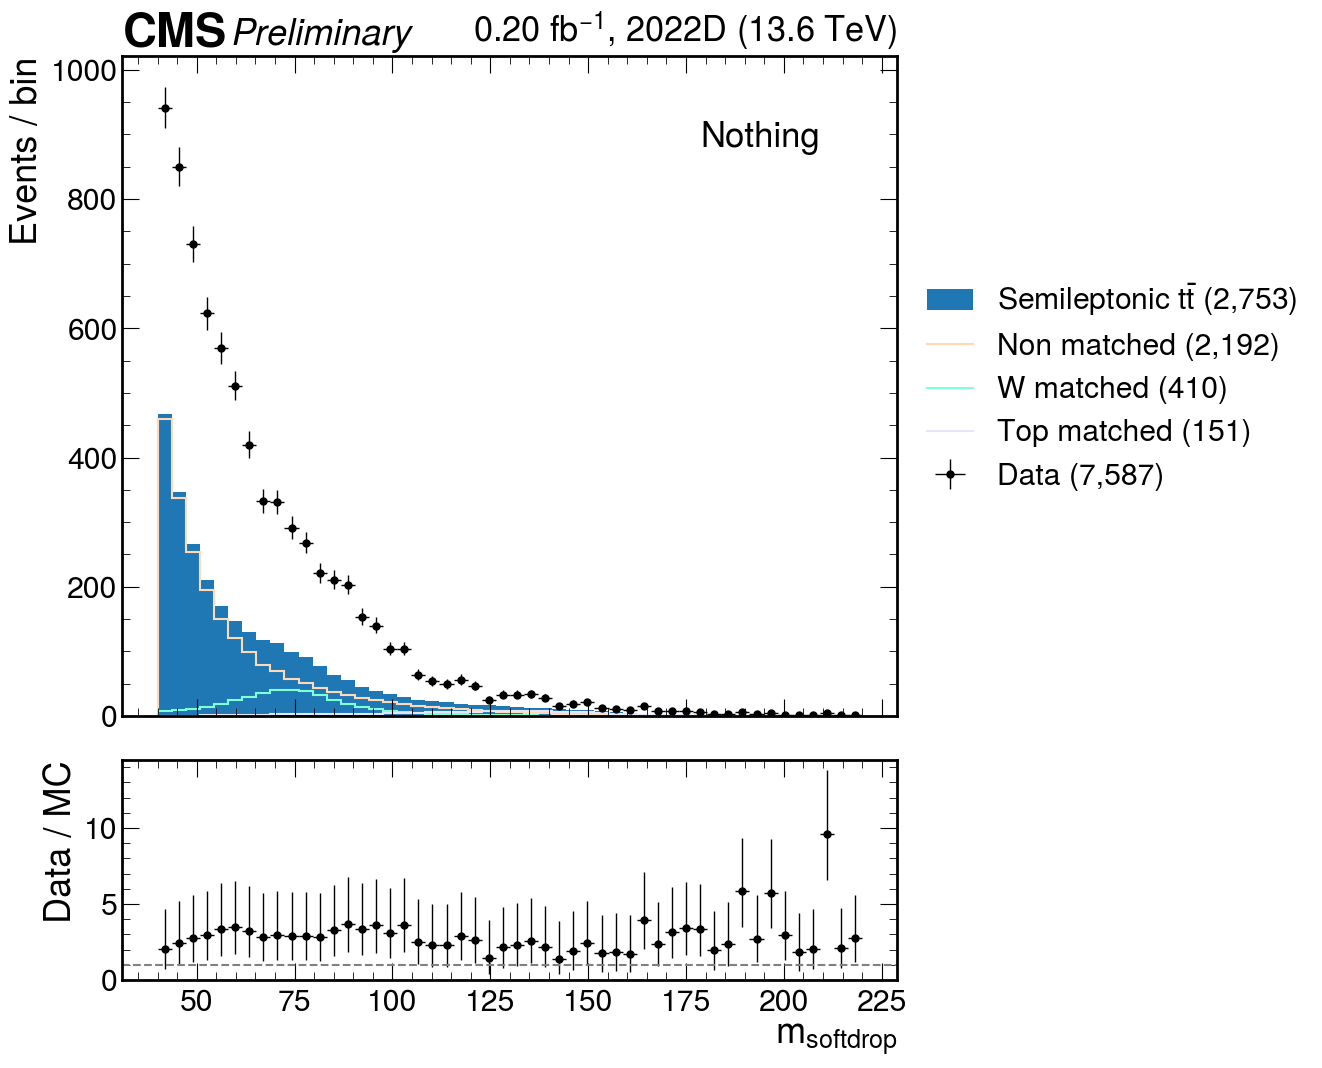

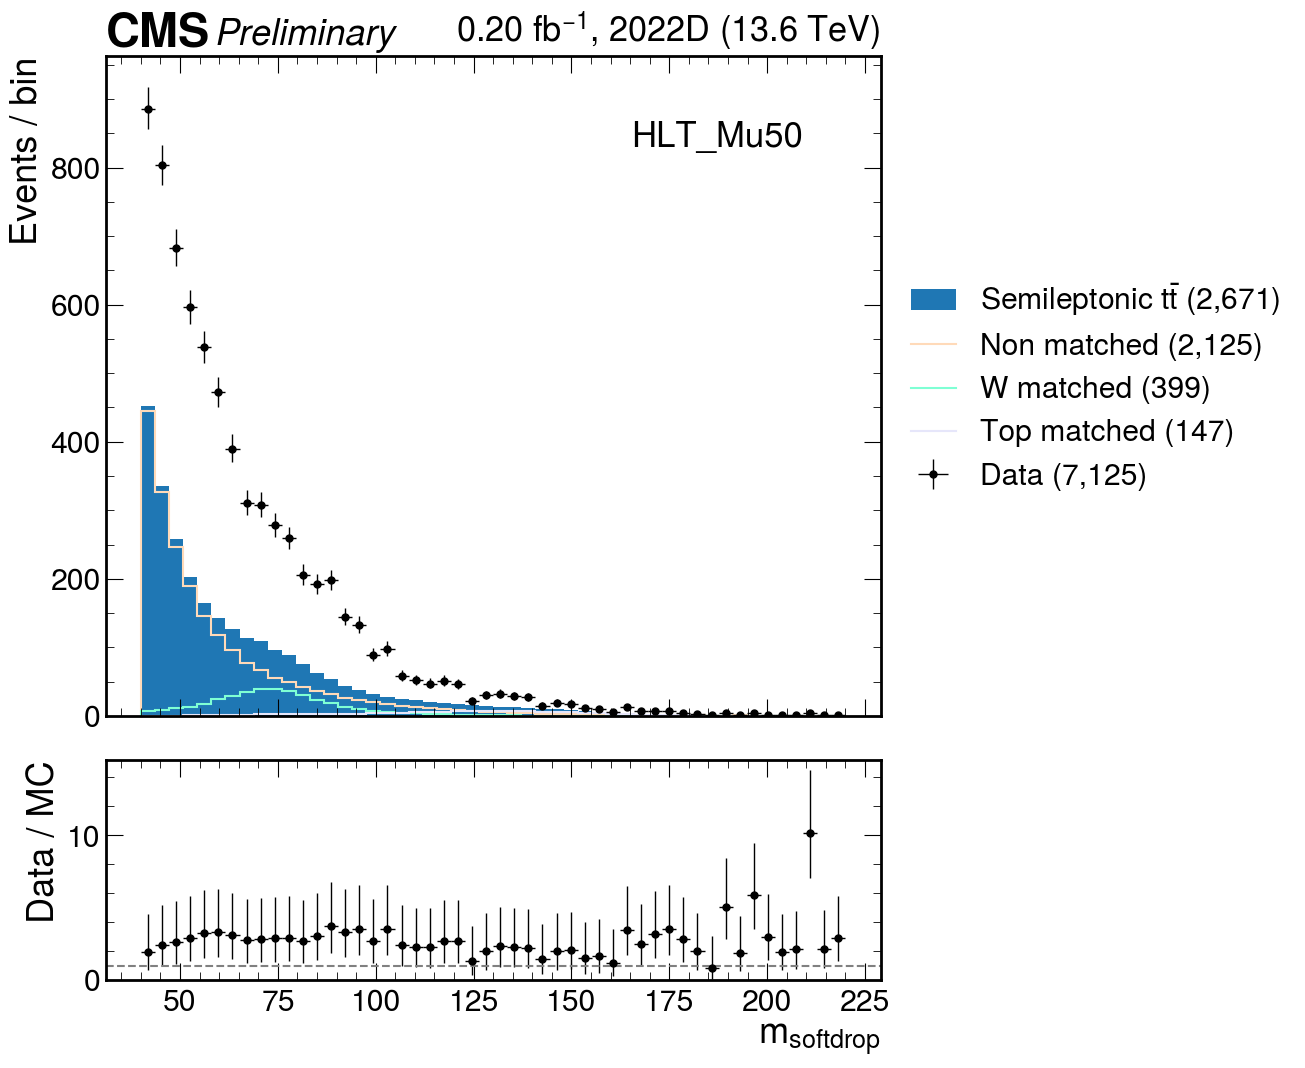

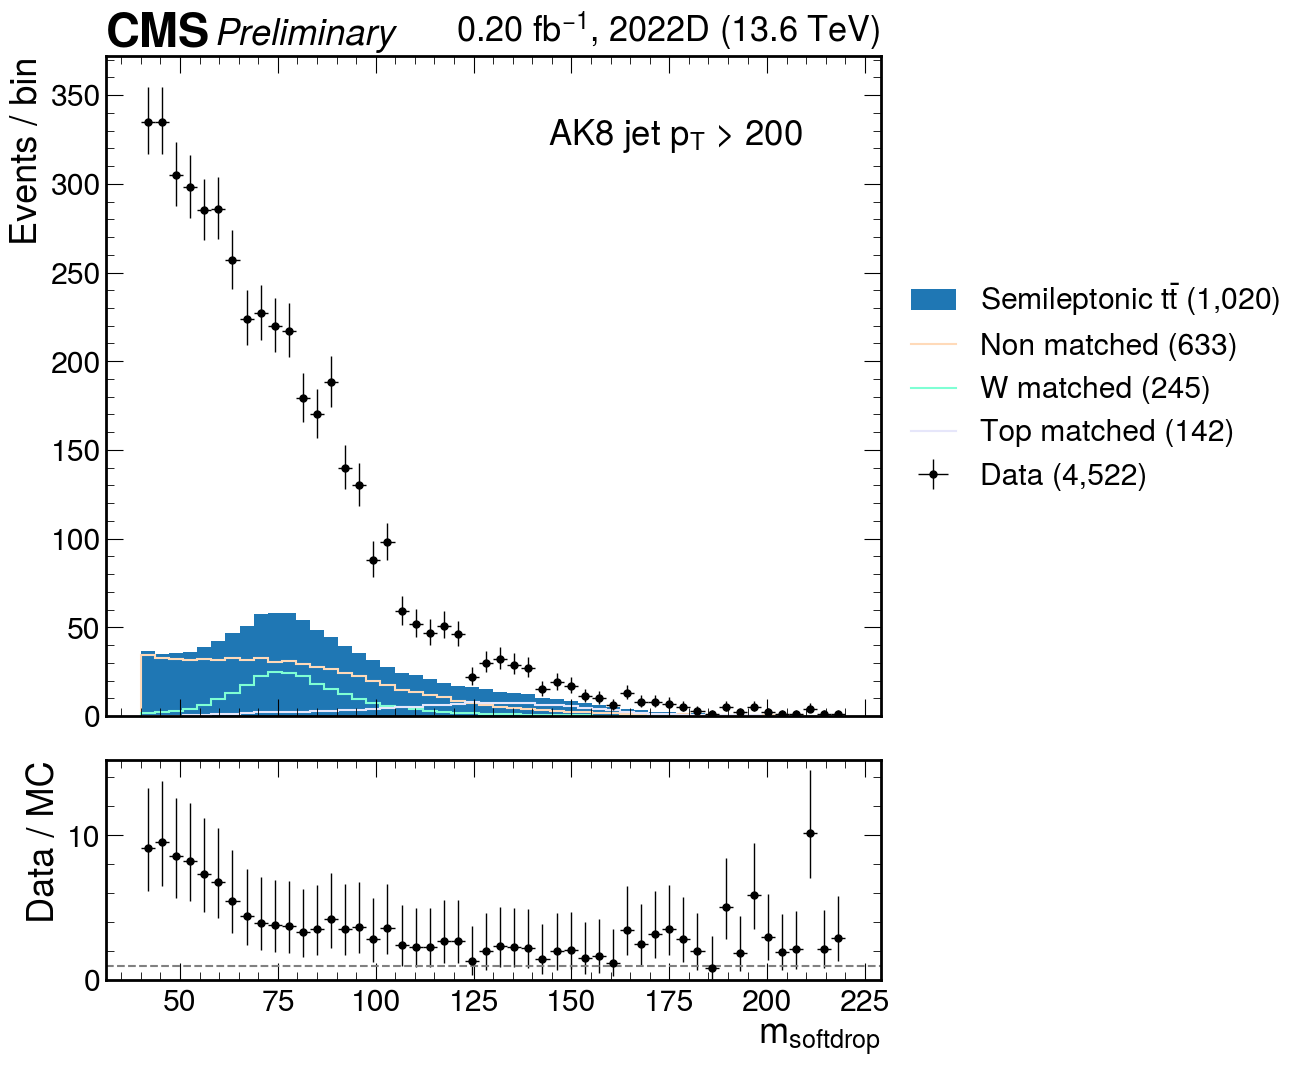

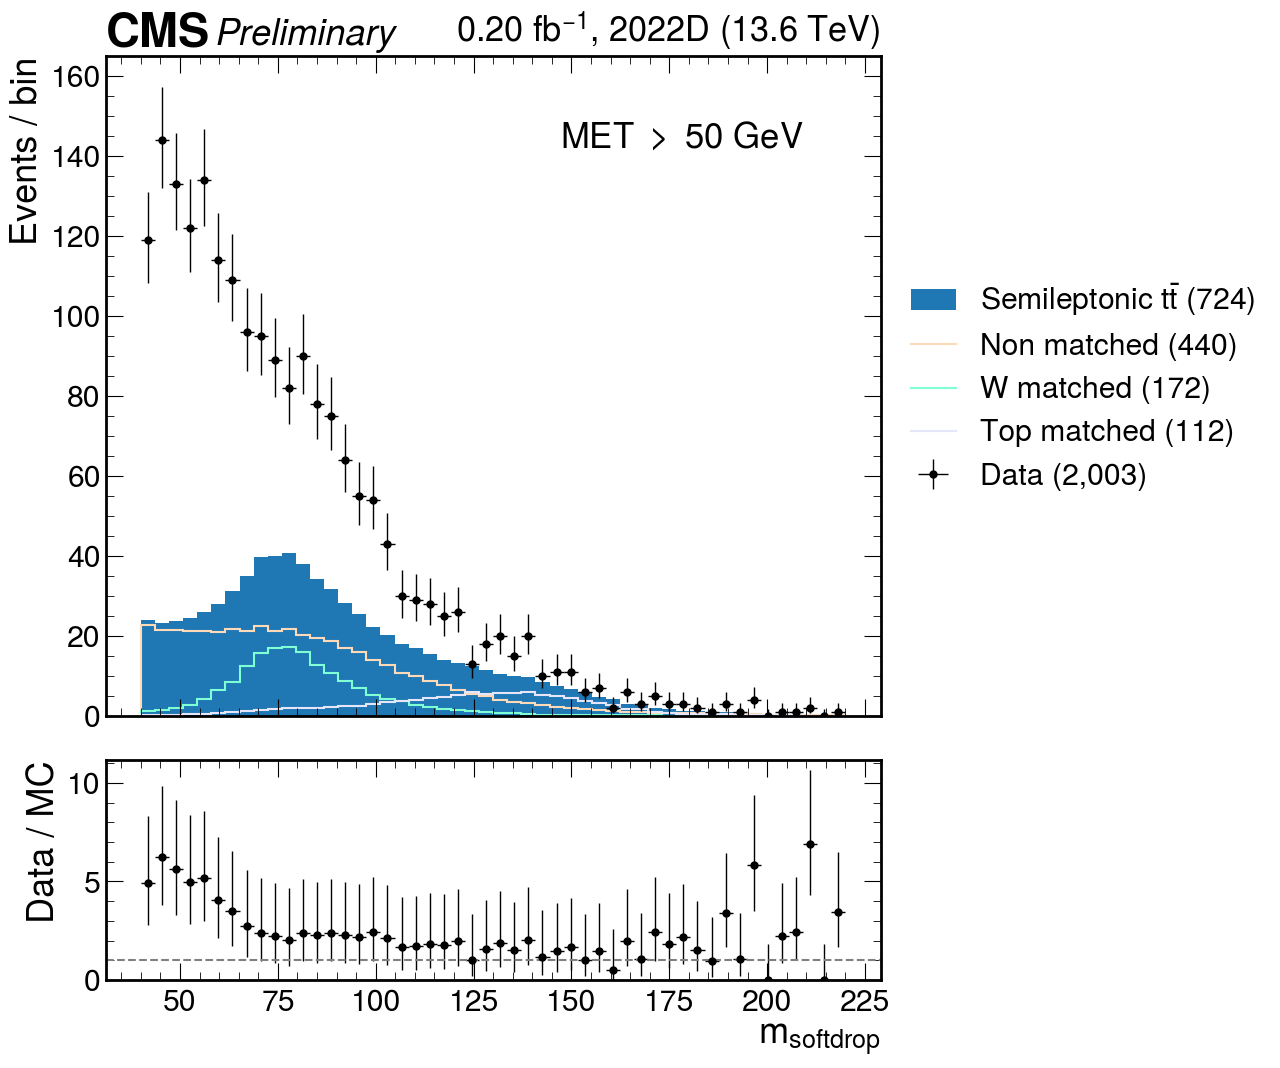

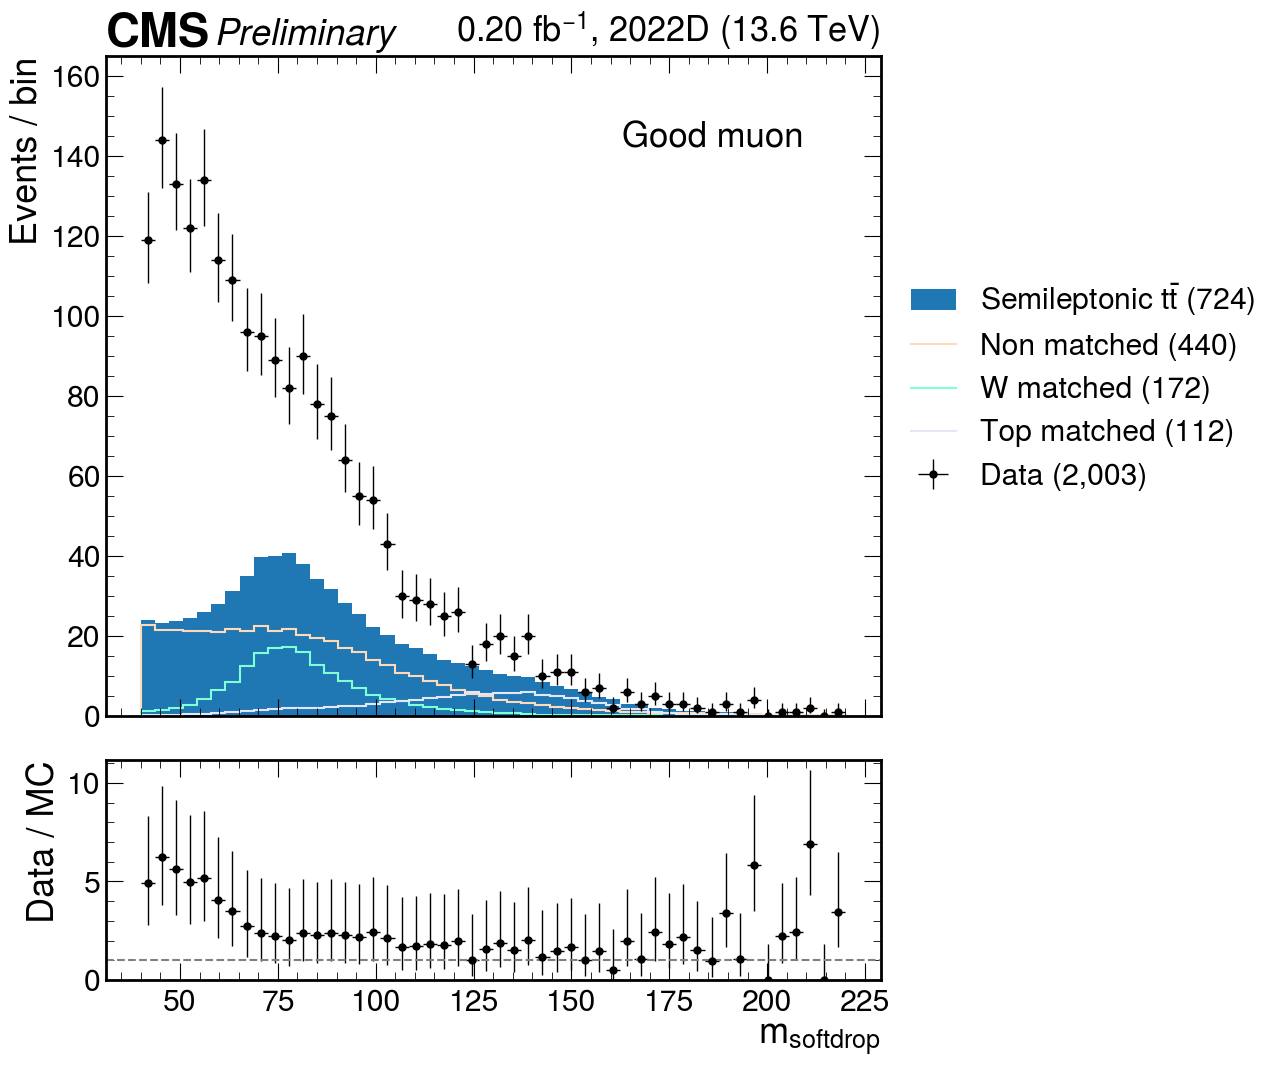

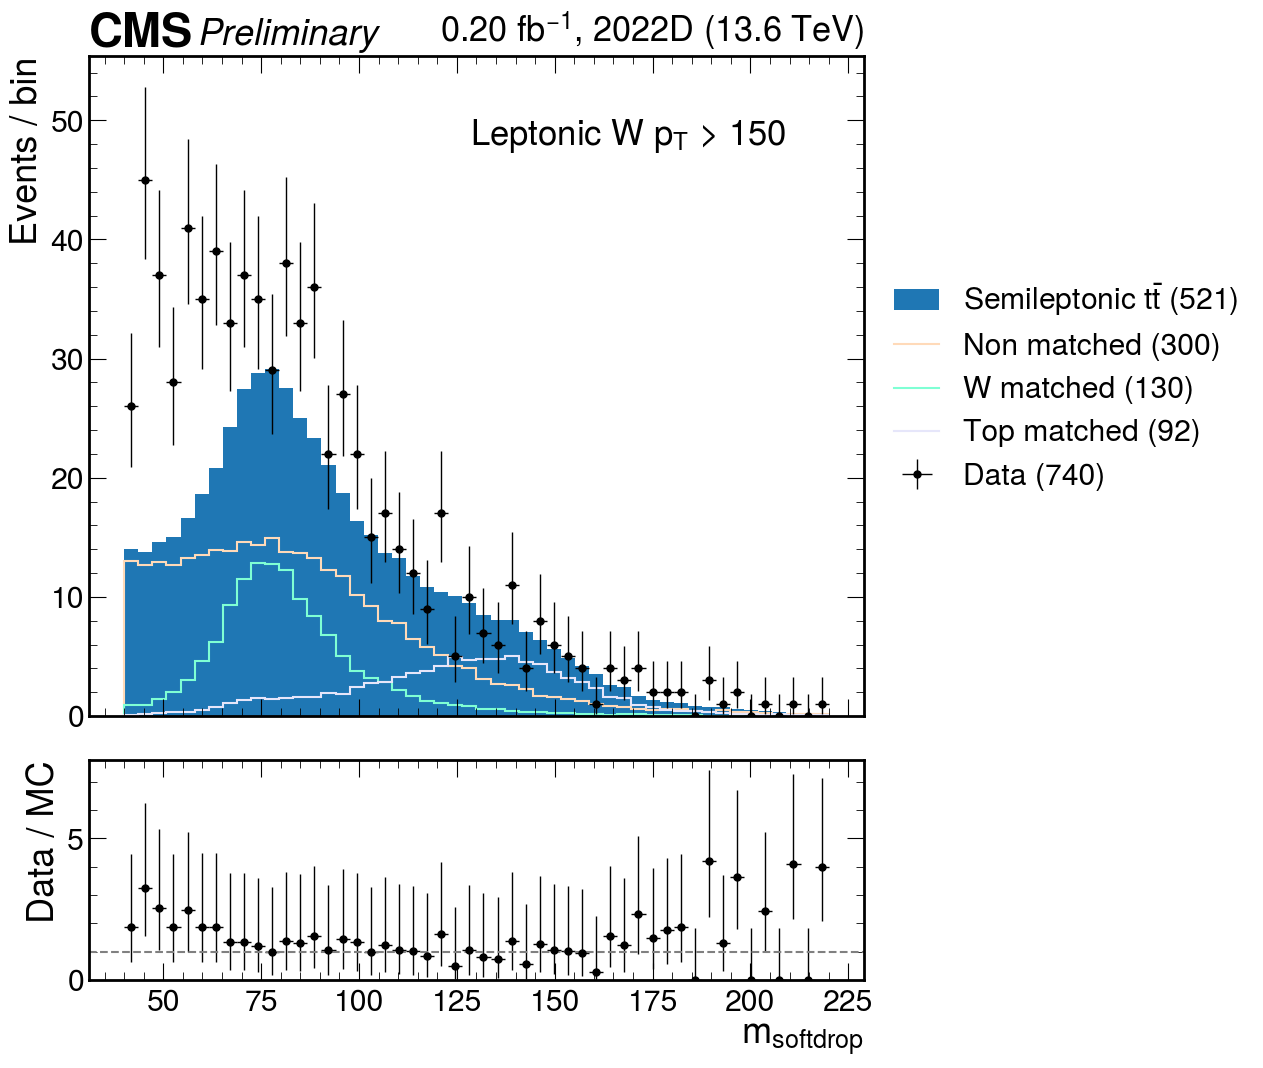

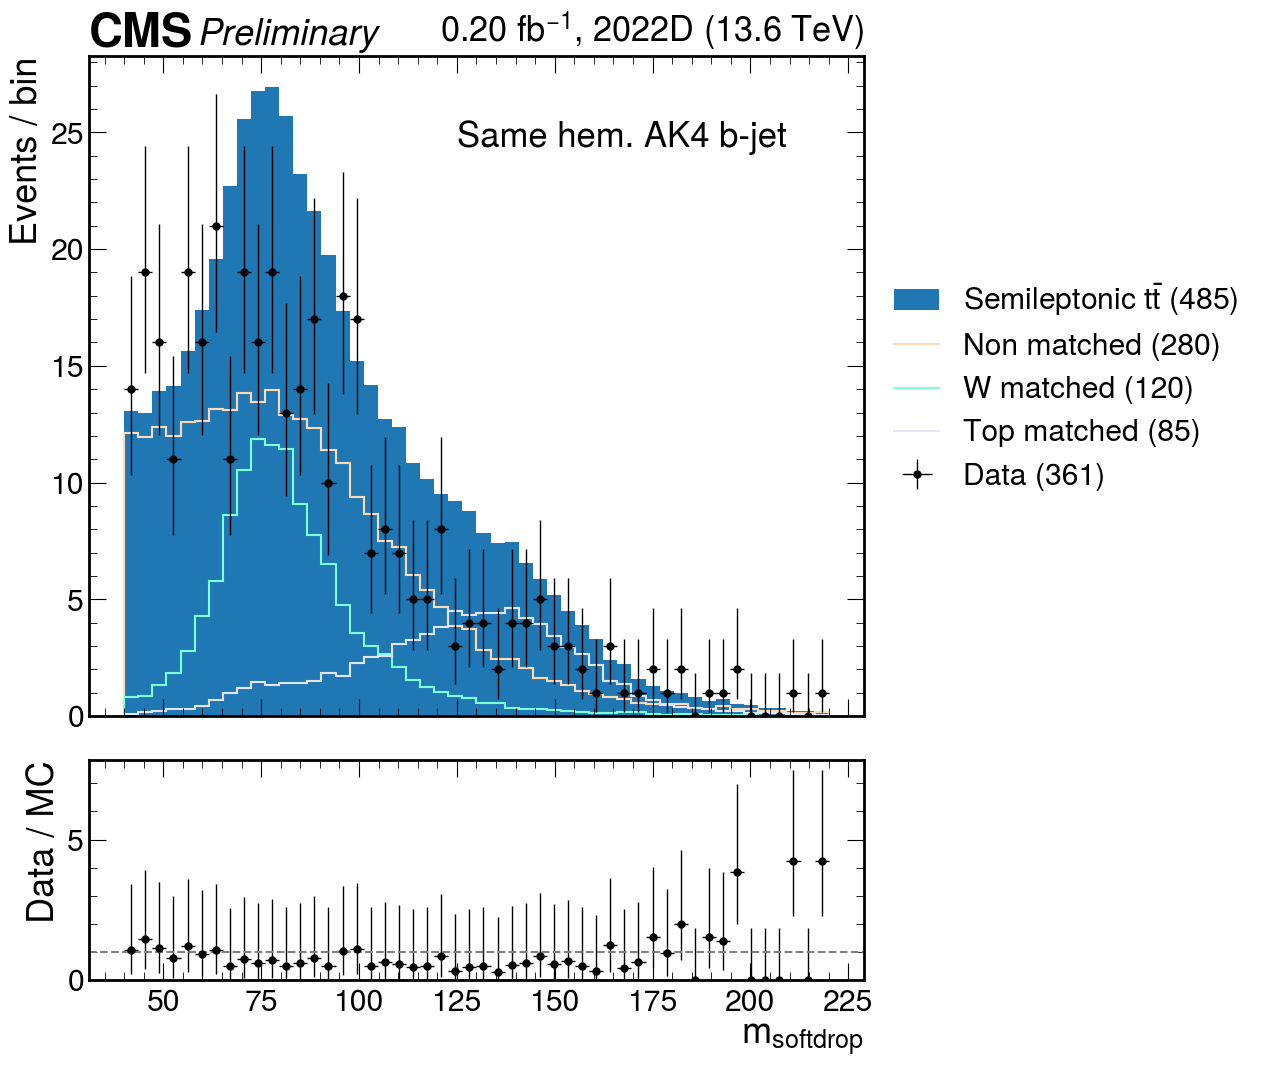

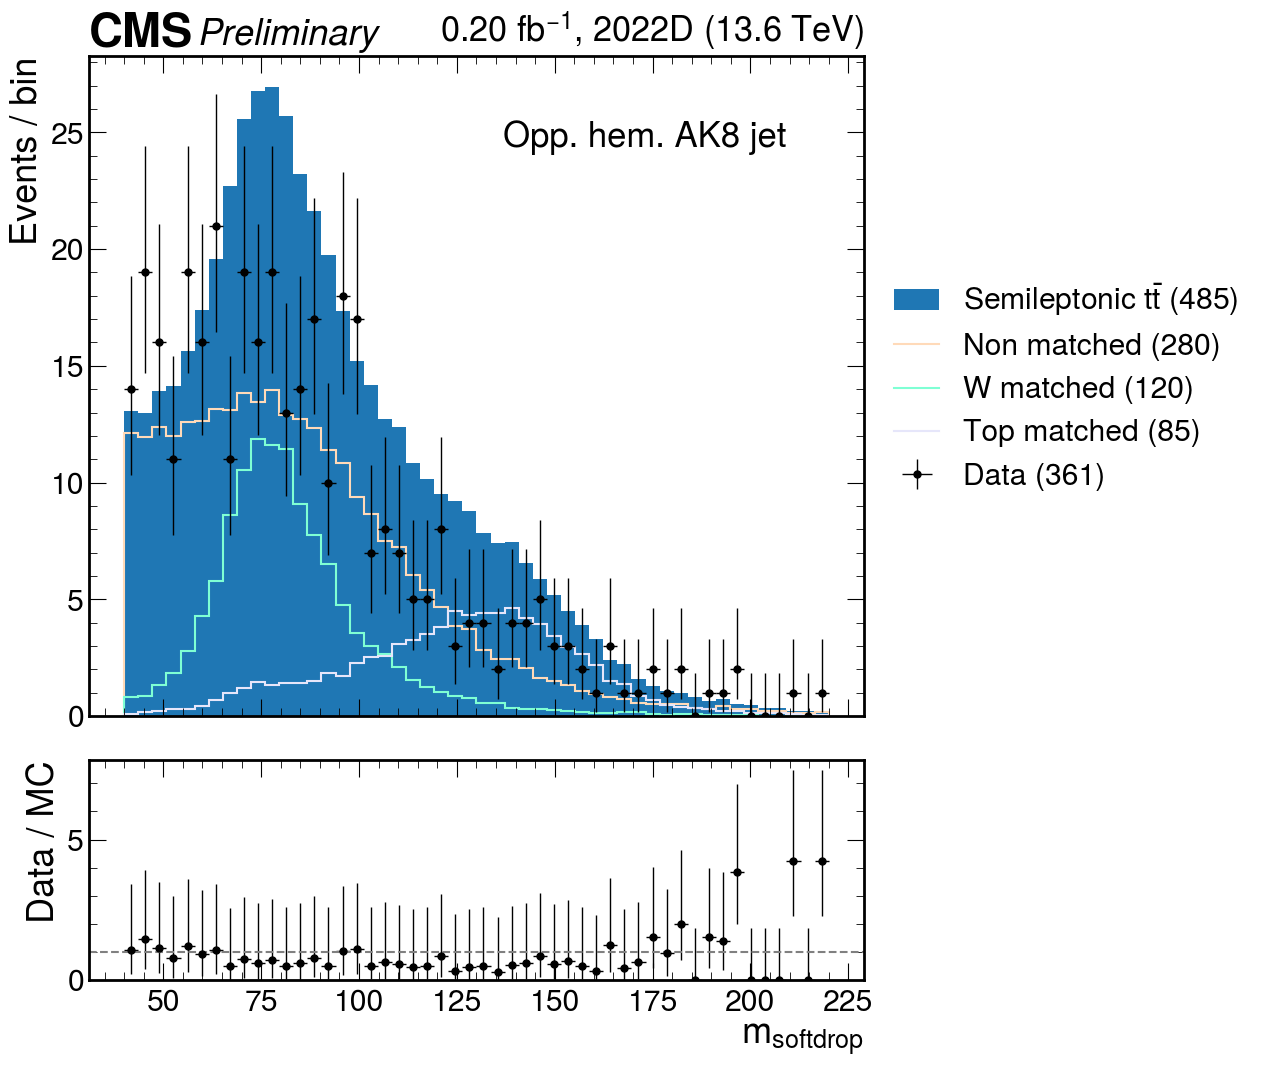

In [101]:
data = util.load("outfiles/cutflow_Run2022D.coffea")[0]
mc = util.load("outfiles/cutflow_TTtoLNu2Q.coffea")[0]

lumis = {
    "2022d" : 195.928715546,
}
xs = {
    "TTtoLNu2Q" : 762.136984,
}
era = "2022d"

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
]

scale_lumi = {k: xs[k] * 1000 * lumis[era] / w for k, w in mc['sumw'].items()}
    
h_data =  data["cutflow"][{
    "cat" : sum,
    "dataset" : sum, 
    "pn_Hbb" : slice(hist.underflow+1, hist.overflow-1, sum), 
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]
h_mc = mc["cutflow"][{
    "pn_Hbb" : slice(hist.underflow+1, hist.overflow-1, sum), 
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi[name]
    
for i in h_mc.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 12), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)
    ax.set_ylabel("Events / bin")
    rax.set_ylabel("Data / MC")
    rax.set_xlabel(r"m$_{softdrop}$")
    ax.set_xlabel(" ")
    
    hh_mc = h_mc[{"dataset" : sum, "cut" : hist.loc(i)}]
    
    mplhep.histplot(
        hh_mc[{"cat" : sum}],
        ax=ax, 
        histtype="fill",
        label=r"Semileptonic $t\bar{t}$" + f" ({hh_mc.sum():,.0f})"
    )
    
    mplhep.histplot(
        [
            hh_mc[{"cat" : hist.loc("non_matched")}],
            hh_mc[{"cat" : hist.loc("w_matched")}],
            hh_mc[{"cat" : hist.loc("top_matched")}],
        ],
        ax=ax,
        label=[
            "Non matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("non_matched")}].sum()),
            "W matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("w_matched")}].sum()),
            "Top matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("top_matched")}].sum()),
        ],
        color=["peachpuff","aquamarine","lavender"]
    )

    hh_data = h_data[{"cut" : hist.loc(i)}]
    
    mplhep.histplot(
        hh_data, 
        ax=ax, 
        histtype="errorbar",
        xerr=True,
        c="black",
        label=f"Data ({hh_data.sum():,.0f})"
    )

    ratio = hh_data/hh_mc[{"cat" : sum}]
    
    mplhep.histplot(
        ratio, 
        ax=rax, 
        histtype="errorbar",
        xerr=True,
        c="black"
    )
    
    rax.axhline(1, color='gray',ls='--')
    
    plt.text(0.9, 0.85, f"{cuts[i]}",
                fontsize=25,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )

    mplhep.cms.label(
            ax=ax, 
            data=True, 
            label="Preliminary",
            year="2022D",
            lumi=f"{lumis[era]/1000:.2f}",
            com=13.6,
        )
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

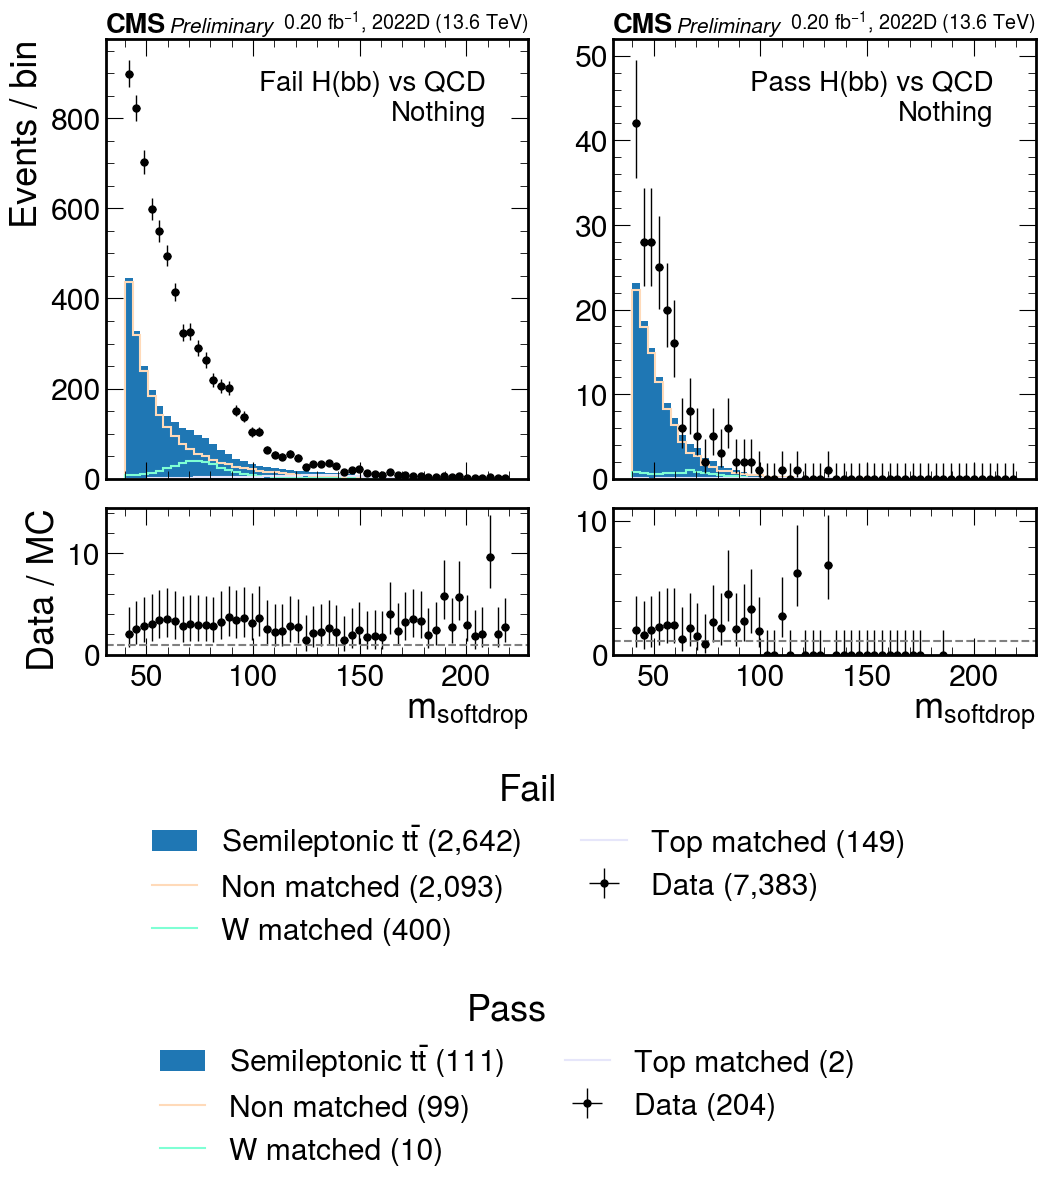

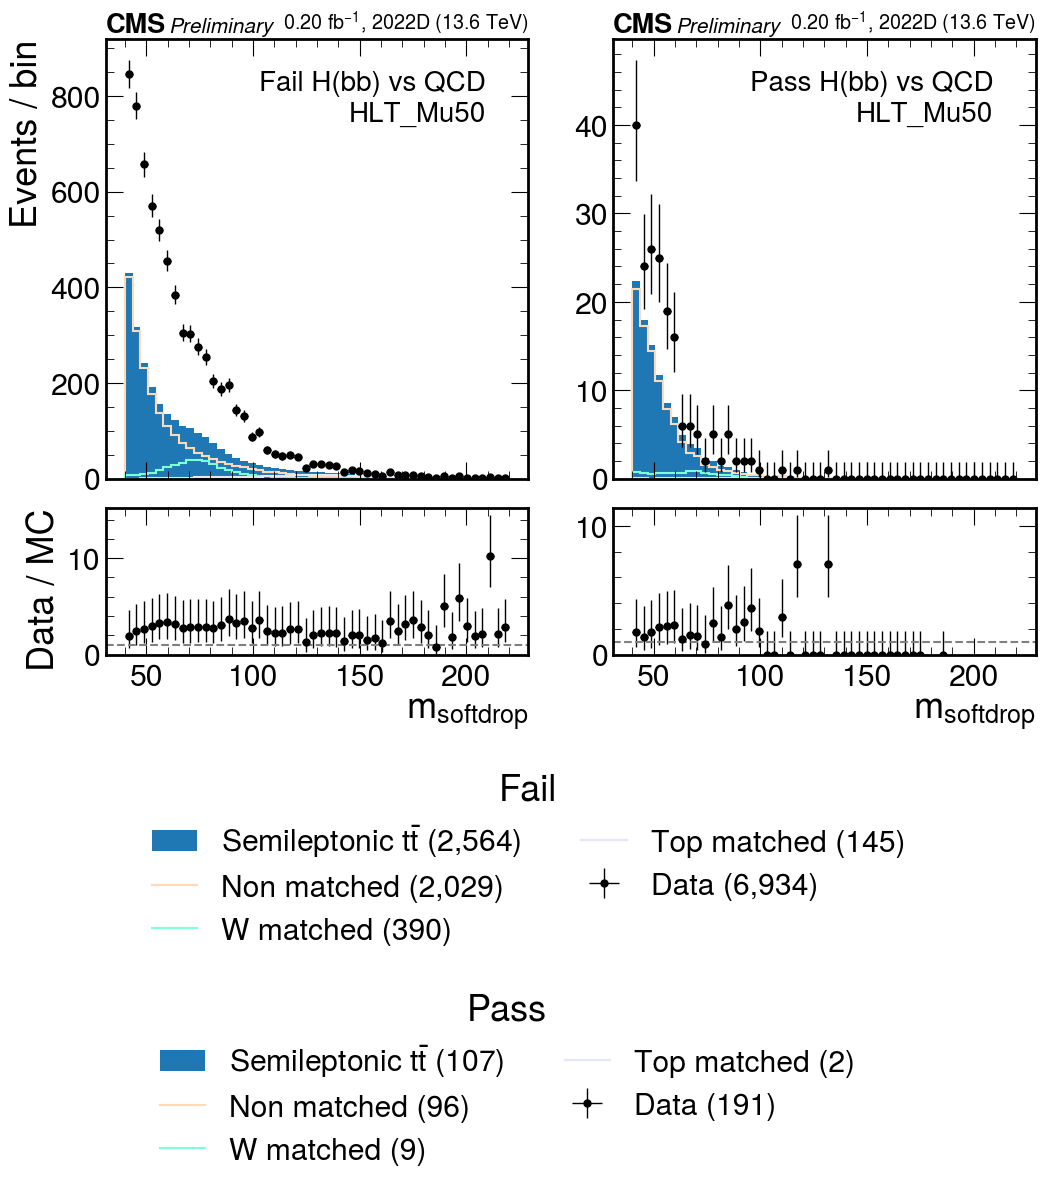

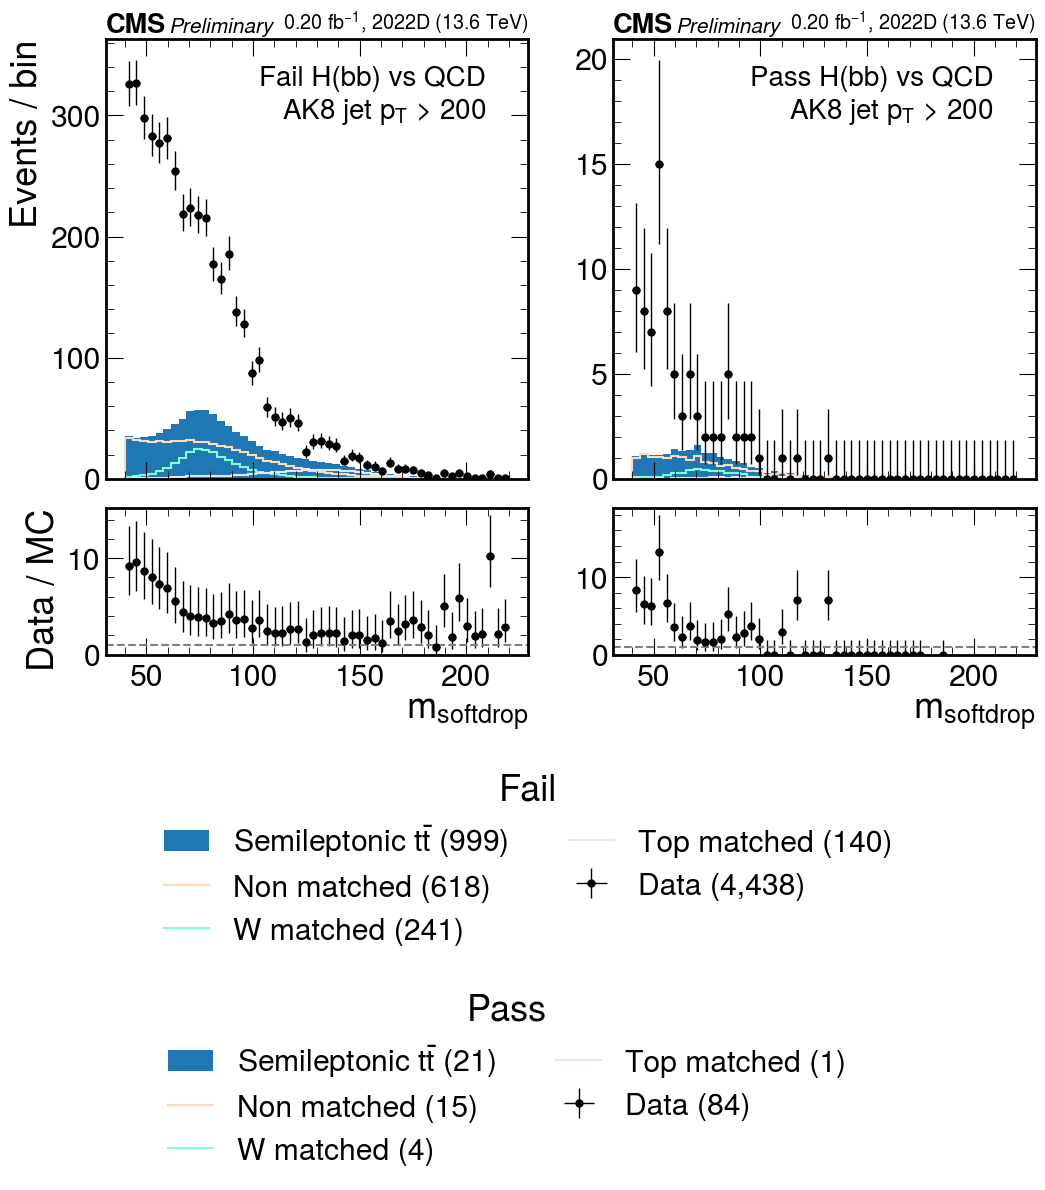

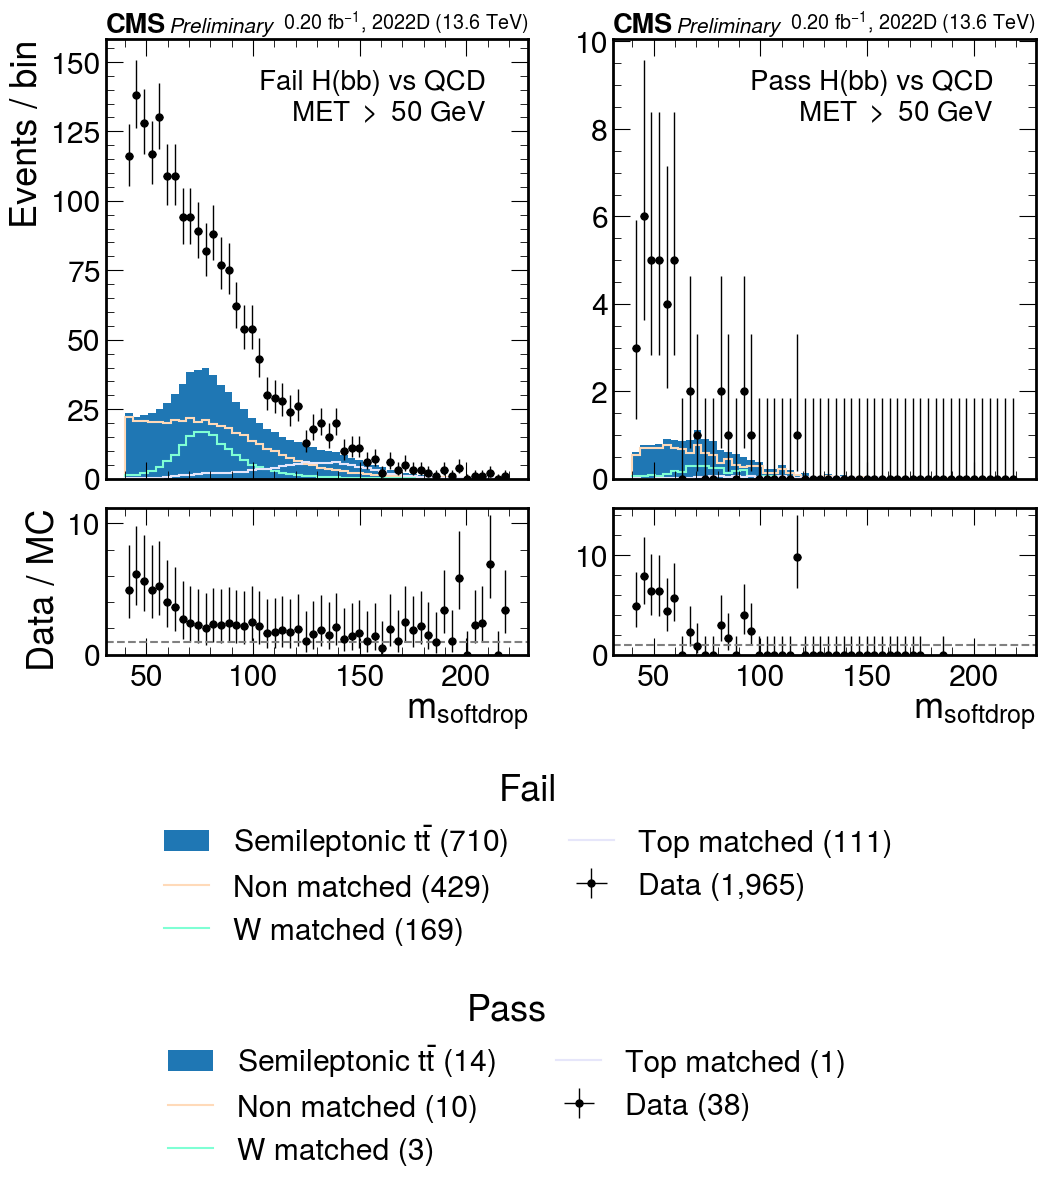

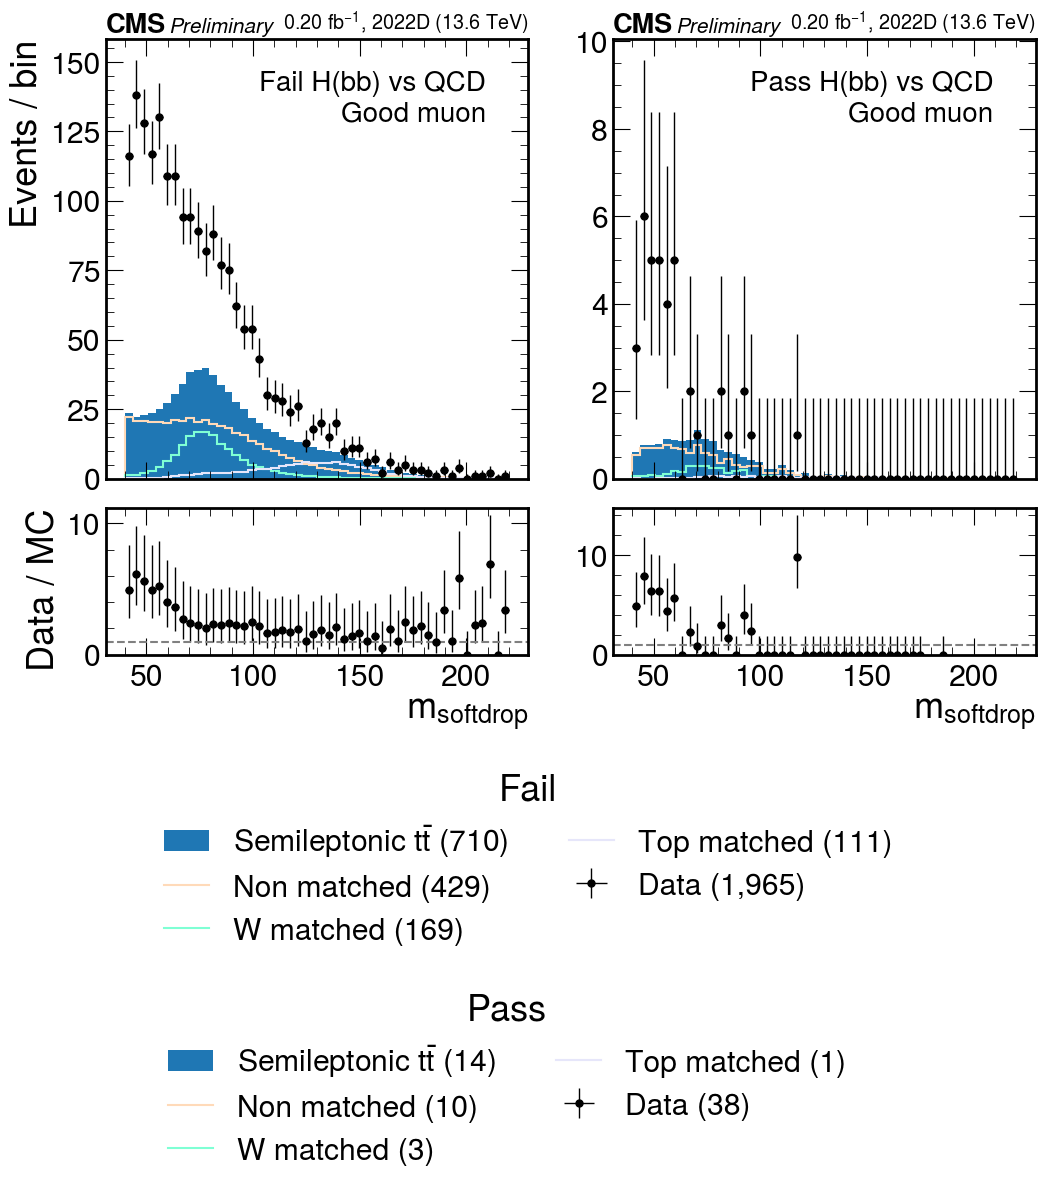

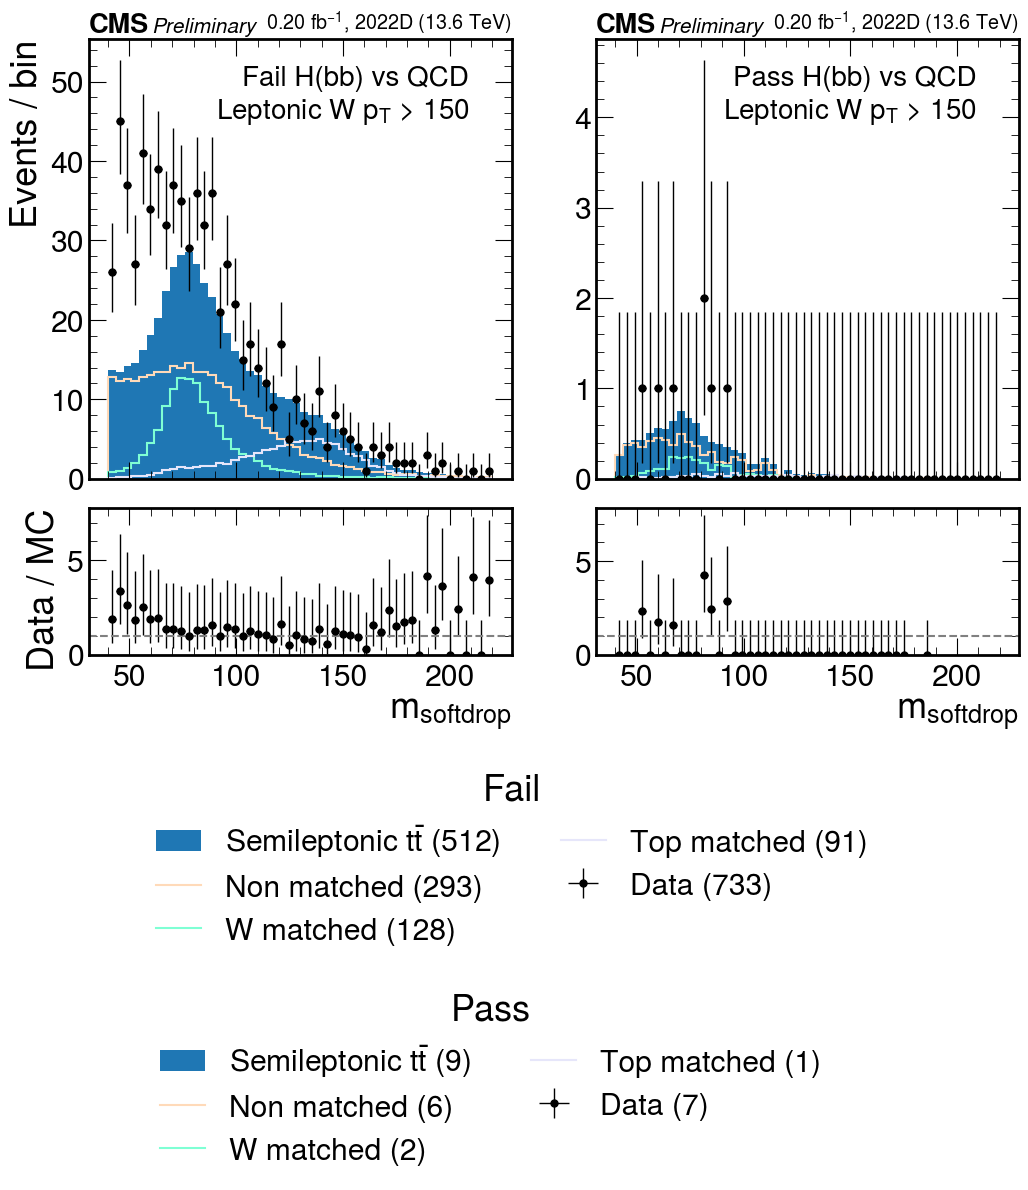

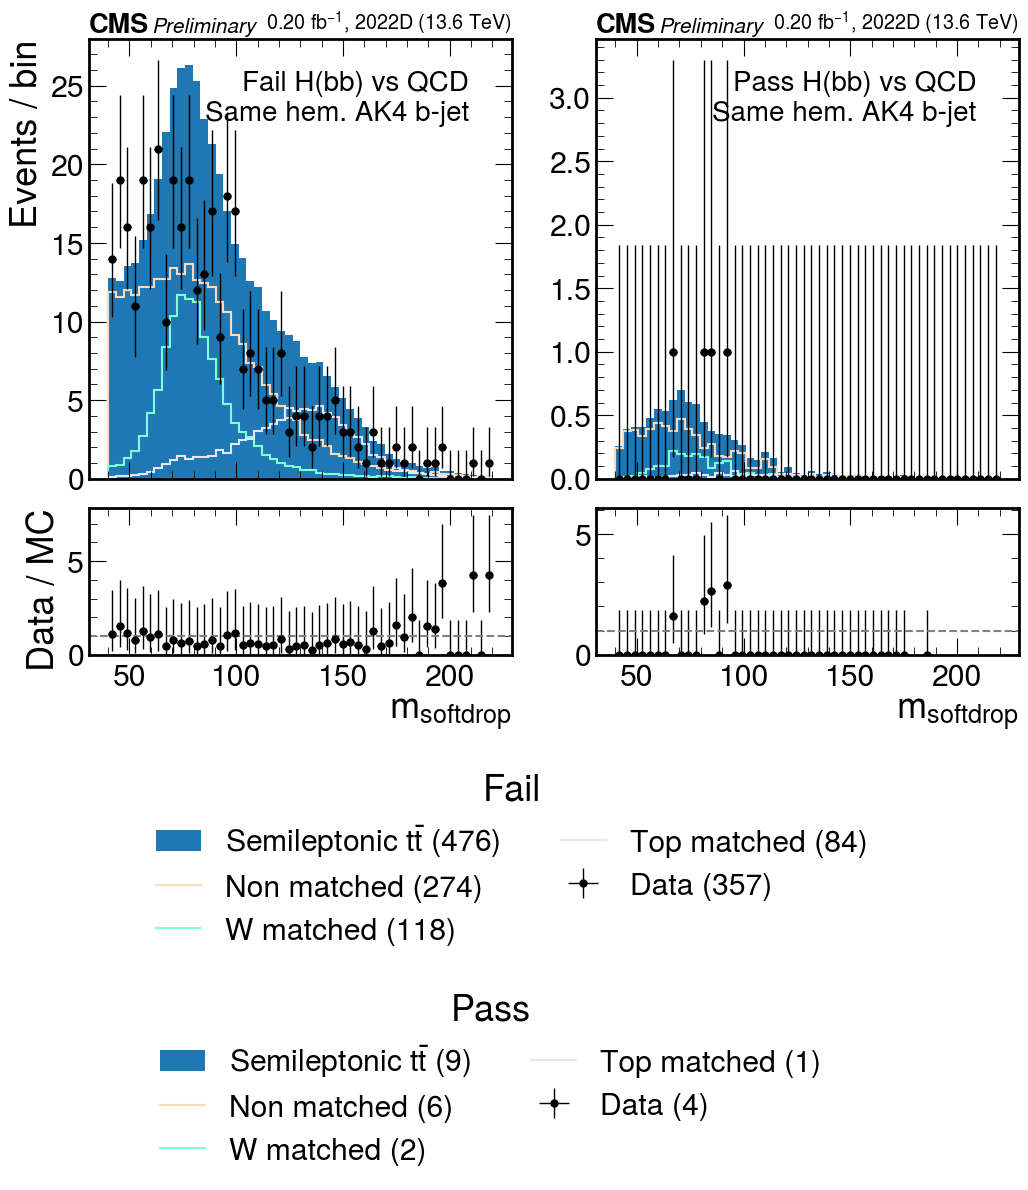

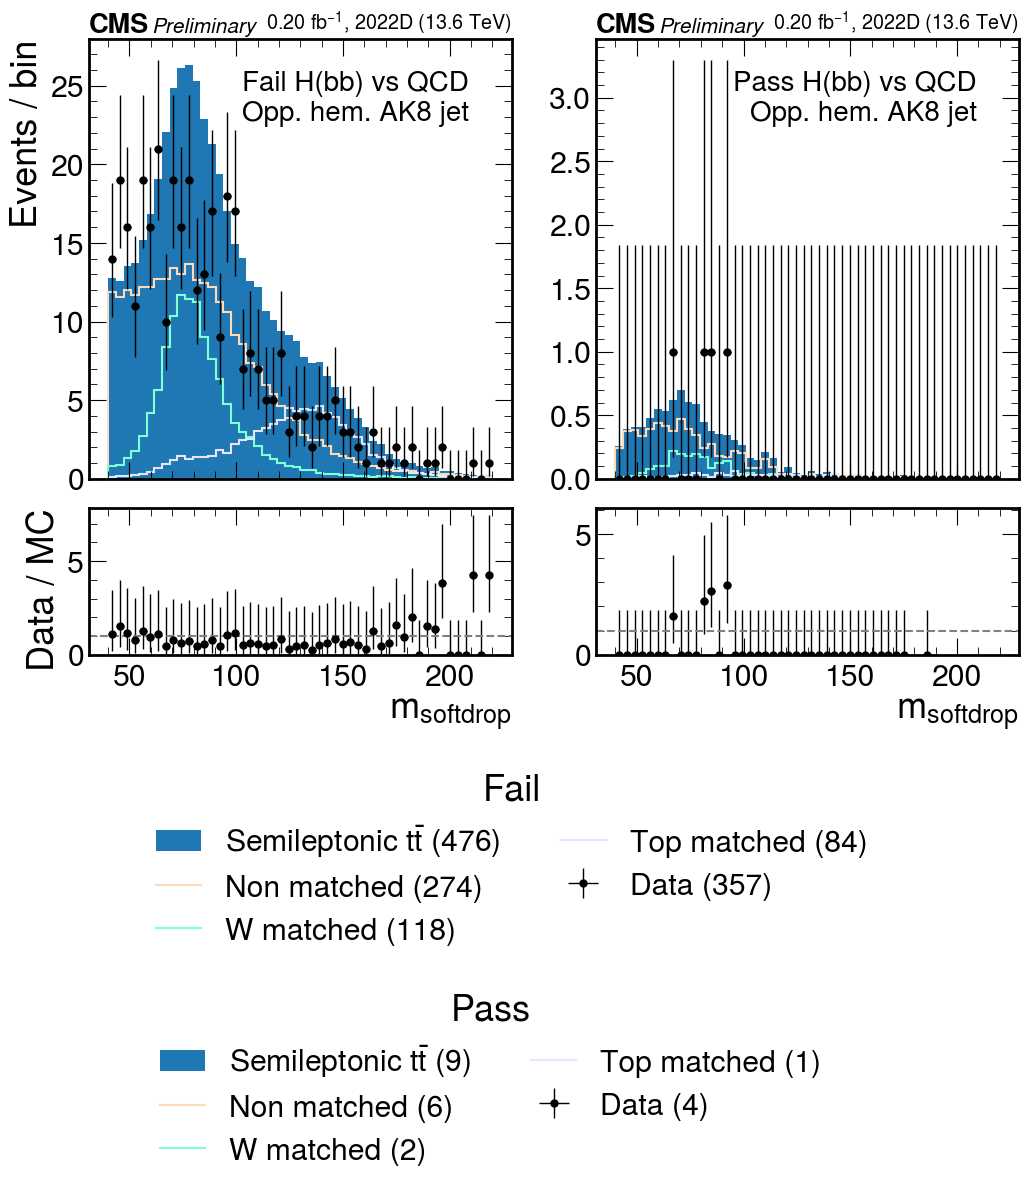

In [103]:
data = util.load("outfiles/cutflow_Run2022D.coffea")[0]
mc = util.load("outfiles/cutflow_TTtoLNu2Q.coffea")[0]

lumis = {
    "2022d" : 195.928715546,
}
xs = {
    "TTtoLNu2Q" : 762.136984,
}
era = "2022d"

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
]

region = {
    0 : "Fail H(bb) vs QCD",
    1 : "Pass H(bb) vs QCD",
}

scale_lumi = {k: xs[k] * 1000 * lumis[era] / w for k, w in mc['sumw'].items()}
    
h_data =  data["cutflow"][{
    "cat" : sum,
    "dataset" : sum,  
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]
h_mc = mc["cutflow"][{
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi[name]
    
for i in h_mc.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 2, figsize=(12, 8), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    
    for j, _ in enumerate(["fail", "pass"]):
    
        fig.subplots_adjust(hspace=0.1)
        ax[j].set_ylabel("Events / bin" if j == 0 else " ")
        rax[j].set_ylabel("Data / MC" if j == 0 else " ")
        rax[j].set_xlabel(r"m$_{softdrop}$")
        ax[j].set_xlabel(" ")

        sli = slice(hist.underflow+1, 0.4j, sum) if j == 0 else slice(0.4j, hist.overflow-1, sum)
        hh_mc = h_mc[{"dataset" : sum, "cut" : hist.loc(i), "pn_Hbb" : sli}]

        mplhep.histplot(
            hh_mc[{"cat" : sum}],
            ax=ax[j], 
            histtype="fill",
            label=r"Semileptonic $t\bar{t}$" + f" ({hh_mc.sum():,.0f})"
        )

        mplhep.histplot(
            [
                hh_mc[{"cat" : hist.loc("non_matched")}],
                hh_mc[{"cat" : hist.loc("w_matched")}],
                hh_mc[{"cat" : hist.loc("top_matched")}],
            ],
            ax=ax[j],
            label=[
                "Non matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("non_matched")}].sum()),
                "W matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("w_matched")}].sum()),
                "Top matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("top_matched")}].sum()),
            ],
            color=["peachpuff","aquamarine","lavender"]
        )

        hh_data = h_data[{"cut" : hist.loc(i), "pn_Hbb" : sli}]

        mplhep.histplot(
            hh_data, 
            ax=ax[j], 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Data ({hh_data.sum():,.0f})"
        )

        ratio = hh_data/hh_mc[{"cat" : sum}]

        mplhep.histplot(
            ratio, 
            ax=rax[j], 
            histtype="errorbar",
            xerr=True,
            c="black"
        )

        rax[j].axhline(1, color='gray',ls='--')

        plt.text(0.9, 0.8, f"{region[j]}\n{cuts[i]}",
                    fontsize=20,
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    transform=ax[j].transAxes
                   )

        mplhep.cms.label(
            ax=ax[j], 
            data=True, 
            label="Preliminary",
            year="2022D",
            lumi=f"{lumis[era]/1000:.2f}",
            com=13.6,
            fontsize=15,
        )
        
    ax[0].legend(loc='upper center', title="Fail", bbox_to_anchor=(1, -0.6), ncol=2)
    ax[1].legend(loc='upper center', title="Pass", bbox_to_anchor=(-0.25, -1.1), ncol=2)